---
# Student Info & Imports

Student info: Nadav Kahlon, ID: 213438575

In [ ]:
# import necessary packages
import torch
import torchvision
import copy
import time
import math
from torch import nn, optim
from tqdm import tqdm
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
from matplotlib import pyplot as plt

# set manual seed for PyTorch (for reproducible results)
torch.manual_seed(0)

# Get available device, preferably GPU
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cpu


---
# Question 1 - A Convolutional Layer
In this question we implement a convolutional neural-network-layer from scratch, featuring pooling (using a stride) and padding.

## Defining the Layer

In [ ]:
'''
A convolutional neural-network layer, implemented from scratch.
'''
class MyConv2d(nn.Module):
    '''
    Constructor: creates a convolutional layer.
    Input:
      > 'in_channels' - the number of channels in the input to the layer.
        Default: 1.
      > 'out_channels' - the number of channels in the output of the layer.
        Default: 1.
      > 'kernel_size' - the height and width of the kernel the layer applies.
        Default: (1,1).
      > 'stride' - horizontal and vertical stride of the kernel. Default: 1.
      > 'padding' - number of zero-rows and zero-columns to pad the image with
        (by appending them to the sides of the image). Default: 0.
    '''
    def __init__(self, in_channels=1, out_channels=1, kernel_size=(1,1),
                 stride=1, padding=0):
        # call Module class constructor to initialize the layer
        super().__init__()

        # store hyper-parameters of the layer
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # set a learnable kernel, initialized using a method inspired by Xavier's
        # initialization (as descirbed in the following cell)
        n_in = kernel_size[0] * kernel_size[1] * in_channels
        n_out = kernel_size[0] * kernel_size[1] * out_channels
        bound = math.sqrt(6/(n_in+n_out))
        kernel_shape = (out_channels, in_channels, kernel_size[0], kernel_size[1])
        kernel = torch.rand(kernel_shape) * (2*bound) - bound
        self.kernel = nn.Parameter(kernel)
    
    '''
    Forward propagation through the convolutional layer.
    Input: tensor of shape (batch_size, in_channels, in_height, in_width)
    Output: tensor of shape (batch_size, out_channels, out_height, out_width) 
      where 'out_height' and 'out_width' are the output dimensions, based on 
      'in_height', 'in_width', the layer's padding and the kernel's stride.
    '''
    def forward(self, input):
        # validate input's shape
        assert len(input.shape) == 4 and input.shape[1] == self.in_channels, \
          f'MyConv2d.forward expected a 4 dimensional input tensor representing ' +\
          f'a batch of 2D samples with {self.in_channels} channels.'
        in_height = input.shape[2]
        in_width = input.shape[3]
        batch_size = input.shape[0]

        # calculate output dimensions and initialize an output tensor
        out_height = ((in_height + 2*self.padding
                       - self.kernel_size[0]) // self.stride) + 1
        out_width = ((in_width + 2*self.padding
                       - self.kernel_size[1]) // self.stride) + 1
        output = torch.empty((batch_size, self.out_channels,
                              out_height, out_width))

        # pad the input with zeros
        if self.padding > 0:
            padded_input = torch.zeros((batch_size, self.in_channels, 
                                        self.padding + in_height + self.padding,
                                        self.padding + in_width + self.padding))
            padded_input[:, :,
                        self.padding : -self.padding,
                        self.padding : -self.padding] = input
        else:
            padded_input = input
        
        # calculate each row-column entry in the output tensor
        for out_i in range(out_height):
            for out_j in range(out_width):
                # crop a window of the input
                in_i = out_i * self.stride
                in_j = out_j * self.stride
                input_window = padded_input[:, :,
                                      in_i : in_i + self.kernel_size[0],
                                      in_j : in_j + self.kernel_size[1]]
                
                # add a singleton output dimension to it
                input_window = torch.unsqueeze(input_window, 1)
                
                # calculate and store the window's convolution output
                output_window = (input_window * # shape (N, 1, in_c, k_h, k_w)
                                 self.kernel) # shape (out_c, in_c, k_h, k_w)
                output_window = torch.sum(output_window, dim=(2, 3, 4)) # shape (N, out_c)
                output[:, :, out_i, out_j] = output_window
        
        return output

## A Note On Kernel Initialization

I decided to initialize the kernel weights using a method inspired by Xavier's initialization method. The issue is that Xavier's method is suited for fully-connected layers, while here we deal with convolutional layers. I wanted to get some inspiration from it, so I went and examined the derivation of the method for a fully connected layer with $n_{in}$ input neurons and $n_{out}$ output neurons, described [here](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html#sec-numerical-stability). I noticed that Xavier's method was derived due to the following 2 facts:
* During forward propagation, to produce the activation of a neuron in a layer, we ***sum* $n_{in}$ products of a weight and a neuron activation in the *previous* layer**.
* During backpropagation, to produce the gradiant of the cost with respect to a neuron in a layer, we ***sum* $n_{out}$ products of a weight and a partial-derivative of the cost with respect to a neuron in the *following* layer** - Each of these products is the affect that the neuron have on the cost, through each of the neurons in the following layer.

Note that both neuron-activations and cost-partial-derivatives, are values that "flow" through the network and we try to keep them from "exploding" or "vanishing" due to repetitive multiplications with weights.

Due to these reasons (and some mathematical derivations), Xavier's method draws the weights from the uniform dirstribution $U(-\sqrt{\frac{6}{n_{in}+n_{out}}}, \sqrt{\frac{6}{n_{in}+n_{out}}})$.

Trying to apply this idea to a convolutional layer with kernel size $(k_h,k_w)$, $i_c$ input channels and $o_c$ output channels, I noticed that due to the way convolutions work we can say that:
* Each neuron in the output is obtained by a ***sum* of $k_h k_w i_c$ products of a kernel weight and a neuron in the *previous* layer**.
* The partial derivative of the cost with respect to a neuron in the input is obtained by a ***sum* of (probably) $k_h k_w o_c$ products of a kernel weight and a partial-derivative of the cost with respect to a neuron in the *following* layer**. I wrote "probably" since neurons around the edges of the input affect less than $k_h k_w o_c$ neurons in the output. However most of the neurons are not around the edges, so this is a good estimate.

All in all - if we would set $n_{in}=k_h k_w i_c$ and $n_{out}=k_h k_w o_c$ Xavier's initialization for the kernel weights with these parameters will be a reasonable approach (for the exact same reason it is reasonable for fully-connected layers). This is the method I used.

## Comparing MyConv2d and torch.nn.Conv2d

In [ ]:
'''
Tests if MyConv2d acts the same as torch.nn.Conv2d for some input tensor.
Input:
  > 'input' - the input tensor to feed to the convolutional layers.
  > 'kernel' - the kernel to test the layers with.
  > 'stride', 'padding' - the stride and padding for both layers. Default: stride=1,
    padding=0.
  > 'tol' - the tolerable difference for declaring that 2 floats are the same in
    the test.
Output: a boolean stating whether or not both an instance of MyConv2d and an instance
  of torch.nn.Conv2d with the given the kernel, stride, and padding, act the same
  on the input tensor.
Note: this routine does not deal with exceptions, so make sure the input is valid.
'''
def testMyConv2d(input, kernel, stride=1, padding=0, tol=5e-4):
    # infer the layers' specifications from the kernel's shape
    kernel_size = (kernel.shape[2], kernel.shape[3])
    in_channels = kernel.shape[1]
    out_channels = kernel.shape[0]

    # create the layers and set their kernels
    my_layer = MyConv2d(in_channels, out_channels, kernel_size, stride, padding)
    my_layer.kernel.data = kernel.clone().detach()
    my_layer.kernel.requires_grad = False
    torch_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride,
                            padding, bias=False)
    torch_layer.weight.data = kernel.clone().detach()
    torch_layer.weight.requires_grad = False

    # evaluate both layers on the given input
    my_output = my_layer(input)
    torch_output = torch_layer(input)

    # and test whether both outputs are the same (up to some tolerable amount)
    return my_output.shape == torch_output.shape and \
           torch.all(torch.abs(my_output - torch_output) < tol)

In [ ]:
# use testMyConv2d on a few input examples:

if testMyConv2d(input=torch.rand(100,3,20,20),
                kernel=torch.rand(64, 3, 9, 9)):
    print('MyConv2D passed its 1st test.')
else: print('MyConv2D did not pass its 1st test.')

if testMyConv2d(input=torch.rand(100,3,50,50)-2,
                kernel=torch.rand(64,3,9,9),
                stride=3, padding=10):
    print('MyConv2D passed its 2nd test.')
else: print('MyConv2D did not pass its 2nd test.')

if testMyConv2d(input=torch.rand(100,3,250,150)*2,
                kernel=torch.rand(128,3,4,9)-0.5,
                stride=10, padding=4):
    print('MyConv2D passed its 3rd test.')
else: print('MyConv2D did not pass its 3rd test.')

if testMyConv2d(input=torch.rand(300,3,30,200)+5,
                kernel=torch.ones(128,3,7,1)*5-3,
                stride=10, padding=17):
    print('MyConv2D passed its 4rd test.')
else: print('MyConv2D did not pass its 4rd test.')

if testMyConv2d(input=torch.rand(300,64,30,200)+5,
                kernel=torch.ones(128,64,1,1),
                stride=6, padding=0):
    print('MyConv2D passed its 5th test.')
else: print('MyConv2D did not pass its 5th test.')

MyConv2D passed its 1st test.
MyConv2D passed its 2nd test.
MyConv2D passed its 3rd test.
MyConv2D passed its 4rd test.
MyConv2D passed its 5th test.


---
# Question 2 - Backpropagation Through a Convolutional Layer
In this question we analyze the gradiant flow through a convolutional layer in a neural network - deriving formulas for the gradiants of the cost with respect to the parameters of the layer (the kernel elements) and the input to it, based on the gradiants of the cost with respect to its output.

* Let $X$ be a 1-channel input image of shape $n_h\times n_w$. We will use the notation $X_{ij}$ to talk about the element in its $i$'th row and $j$'th column ($ 0\leq i \leq n_h-1,\, 0\leq j \leq n_w-1 $).

* Let $K$ be a 1-channel to 1-channel convolutional kernel of shape $k_h\times k_w$. We will use the notation $K_{ij}$ to talk about the element in its $i$'th row and $j$'th column ($ 0\leq i \leq k_h-1,\, 0\leq j \leq k_w-1 $).

* Let $Y$ be the 1-channel output image resulting from applying the convolutional kernel $K$ on input image $X$. It is an image of shape $(n_h-k_h+1)\times(n_w-k_w+1)$ and we will use the notation $Y_{rs}$ to talk about the element in its $r$'th row and $s$'th column ($ 0\leq r \leq n_h-k_h,\, 0\leq s \leq n_w-k_w $). This element can be expressed as:

  (1) $Y_{rs}=\sum_{i=0}^{k_h-1}\sum_{j=0}^{k_w-1}K_{ij}X_{r+i,s+j}$
  $\newcommand{\gradc}[1]{\frac{\partial C}{\partial #1}}$
  $\newcommand{\grad}[2]{\frac{\partial #1}{\partial #2}}$

* We also assume we have the gradiant of some cost function $C$ with respect to the output $Y$. In other word, we assume that for every $ 0\leq r \leq n_h-k_h,\, 0\leq s \leq n_w-k_w $, we know the value of $\gradc{Y_{rs}}$.

Let's start by calculating the gradiant of the cost with respect to parameter $K$. Each element $K_{ij}$ ($ 0\leq i \leq k_h-1,\, 0\leq j \leq k_w-1 $) affects the cost only through the output of the convolution - $Y$. Therefore we can write:

(2) $\gradc{K_{ij}}=\sum_{r=0}^{n_h-k_h}\sum_{s=0}^{n_w-k_w}\gradc{Y_{rs}}\grad{Y_{rs}}{K_{ij}}$

And from (1) we can easily derive:

$\grad{Y_{rs}}{K_{ij}}=X_{r+i,s+j}$

And by plugging it into (2) we get:

$\gradc{K_{ij}}=\sum_{r=0}^{n_h-k_h}\sum_{s=0}^{n_w-k_w}(\gradc{Y_{rs}}\cdot X_{r+i,s+j})$

Now let's calculate the gradiant of the cost with respect to input $X$. Each element $X_{rs}$ ($ 0\leq r \leq n_h-1,\, 0\leq s \leq n_w-1 $) can affect the cost only through the output image $Y$. From (1) we can infer that an element $Y_{r's'}$ in the output ($ 0\leq r' \leq n_h-k_h,\, 0\leq s' \leq n_w-k_w $) is affected by $X_{rs}$ if and only if $r'=r-i,\,s'=s-j$ for some $ 0\leq i \leq k_h-1,\, 0\leq j \leq k_w-1 $, in which case $\grad{Y_{r's'}}{X_{rs}}=K_{ij}$.

This assertion is valid **assuming that such an element exists in $Y$**, i.e. assuming that:

$ 0\leq r' \leq n_h-k_h,\, 0\leq s' \leq n_w-k_w $

Which is equivalent to:

$ 0\leq r-i \leq n_h-k_h,\, 0\leq s-j \leq n_w-k_w $

Which in turn, is equivalent to:

$r-n_h+k_h \leq i \leq r,\, s-n_w+k_w\leq j \leq s$

Remeber that we also required that:

$ 0\leq i \leq k_h-1,\, 0\leq j \leq k_w-1 $

So all in all, the above mentioned assertion should be true as long as:

$max(0,r-n_h+k_h) \leq i \leq min(k_h-1,r),\,max(0,s-n_w+k_w) \leq j \leq min(k_w-1,s)$

Let's have a quick recap: each element $X_{rs}$ ($ 0\leq r \leq n_h-1,\, 0\leq s \leq n_w-1 $) affects the cost only through $Y_{r-i,s-j}$ for every $max(0,r-n_h+k_h) \leq i \leq min(k_h-1,r),\,max(0,s-n_w+k_w) \leq j \leq min(k_w-1,s)$, in which case $\grad{Y_{r-i,s-j}}{X_{rs}}=K_{ij}$

Using the chain rule we can obtain:

$\gradc{X_{rs}}=\sum_{i=max(0,r-n_h+k_h)}^{min(k_h-1,r)} \sum_{j=max(0,s-n_w+k_w)}^{min(k_w-1,s)}(\gradc{Y_{r-i,s-j}}\cdot K_{ij})$

So to sum up:

* For every $ 0\leq i \leq k_h-1,\, 0\leq j \leq k_w-1 $:

  $\gradc{K_{ij}}=\sum_{r=0}^{n_h-k_h}\sum_{s=0}^{n_w-k_w}(\gradc{Y_{rs}}\cdot X_{r+i,s+j})$

* For every $ 0\leq r \leq n_h-1,\, 0\leq s \leq n_w-1 $:

  $\gradc{X_{rs}}=\sum_{i=max(0,r-n_h+k_h)}^{min(k_h-1,r)} \sum_{j=max(0,s-n_w+k_w)}^{min(k_w-1,s)}(\gradc{Y_{r-i,s-j}}\cdot K_{ij})$

The specific scenario about which we were asked is one in which $n_h=n_w=3,\,k_h=2,\,k_w=1$, and we can get the required gradiants by simply plugging in those values:

* For every $ 0\leq i \leq 1$:

  $\gradc{K_{i0}}=\sum_{r=0}^{1}\sum_{s=0}^{2}(\gradc{Y_{rs}}\cdot X_{r+i,s})$

* For every $ 0\leq r \leq 2,\, 0\leq s \leq 2 $:

  $\gradc{X_{rs}}=\sum_{i=max(0,r-1)}^{min(1,r)} (\gradc{Y_{r-i,s}}\cdot K_{i,0})$

---
# Question 3 - Transfer Learning With ResNet18 on CIFAR-10
In this question we apply transfer learning to classify images in the CIFAR-10 dataset. We use the feature-extraction part of the pre-trained ResNet18 model, and fit a classifier for the CIFAR-10 dataset on top of it. We analyze the results, and compare them to those obtained by a freshly-new residual network trained from scratch.

## Part A-C: Preparing the Data

In [ ]:
# load the CIFAR-10 dataset
trans = transforms.Compose(
    [transforms.PILToTensor(),
     transforms.Resize(224),
     transforms.ConvertImageDtype(torch.float),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
     ])
train_data = torchvision.datasets.CIFAR10(
    root="/CIFAR-10", train=True, download=True,
    transform=trans)
test_data = torchvision.datasets.CIFAR10(
    root="/CIFAR-10", train=False,
    transform=trans)

# create dataloader for train data and test data
train_dataloader = DataLoader(train_data, batch_size=256,
                              num_workers=2,shuffle=True,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=256,pin_memory=True)

# also, load a "raw" version of the data (without any transformations) 
# for visualization
raw_train_data = torchvision.datasets.CIFAR10(root="/CIFAR-10", train=True)
raw_test_data = torchvision.datasets.CIFAR10(root="/CIFAR-10", train=False)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /CIFAR-10/cifar-10-python.tar.gz to /CIFAR-10


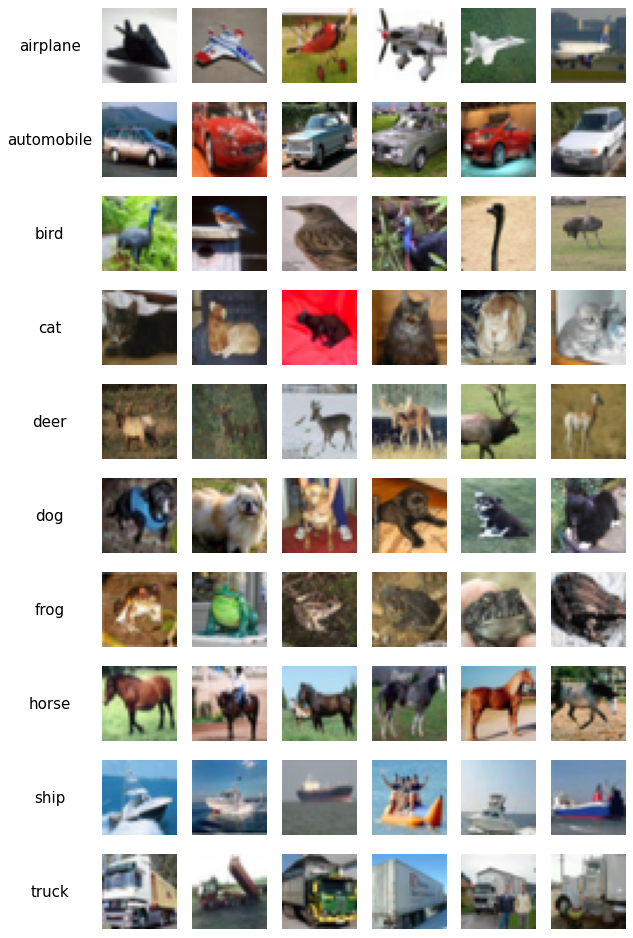

In [ ]:
''' In this cell we visualize a few training samples from each class '''

figure = plt.figure(figsize=(11,17))

to_draw = 6 # no. of samples to visualize from each class
rows = len(raw_train_data.classes) # no. of rows: one row for each class
cols = 1 + to_draw # no. of columns: 1 for the class name + 1 for each sample

# print the names of the classes in the first column of the plot
for classI in range(len(raw_train_data.classes)):
    ax = figure.add_subplot(rows, cols, classI * cols + 1)
    ax.axis('off')
    ax.text(0.5, 0.5, raw_train_data.classes[classI],
            ha='center', va='center', fontdict={'size':15})

# a list to keep track of the number of drawn samples from each class
drawn = torch.zeros(len(raw_train_data.classes), dtype=int)

# visualize enough samples from each class
for img, classI in raw_train_data:
    if drawn[classI] < to_draw:
        # draw sample
        ax = figure.add_subplot(rows, cols, classI * cols + drawn[classI] + 2)
        ax.axis('off')
        ax.imshow(img)

        # update the number of drawn samples from this class
        drawn[classI] += 1
        # break if the plot is full
        if torch.all(drawn == to_draw):
            break

plt.show()

## Parts D-F: Transfer Learning From the Pre-trained ResNet18

In [ ]:
'''
Trains a neural network on the CIFAR-10 dataset prepared above.
Input:
  > 'model' - the model to fit.
  > 'criterion' - the loss measure.
  > 'optimizer' - the optimizer to train with; if the optimizer is attached to
    only some of the model's parameters, only those are trained (suitable for
    transfer learning).
  > 'scheduler' - a scheduler object that will step every epoch.
  > 'epochs' - the number of training epochs.
Outputs a pair of lists of the loss and accuracy histories during training.
'''
def train_model(model, criterion, optimizer, scheduler=None, epochs=25):
    # record starting time
    start_time = time.time()

    # lists to record loss and accuracy histories
    loss_hist = []
    acc_hist = []

    model.train()
    for epoch in range(epochs):

        # Iterate over data batches
        for imgs, labels in tqdm(train_dataloader,
                                 f'epoch {epoch+1} / {epochs}',
                                 position=0, leave=True):
        
            # move batch to the working device
            imgs = imgs.to(device)
            labels = labels.to(device)

            # forward propagation
            optimizer.zero_grad()
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            acc = torch.sum(preds == labels.data) / len(labels)
            
            # backpropagation
            loss.backward()
            optimizer.step()
            if scheduler != None: scheduler.step()

            # record batch performance
            loss_hist += [loss.item()]
            acc_hist += [acc.item()]

    # calculate and inform the user about the time elapsed
    time_elapsed = time.time() - start_time
    print(f'\nTraining completed in ' +
          f'{time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return loss_hist, acc_hist

In [ ]:
# import the pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)
criterion = nn.CrossEntropyLoss()

# disable gradiant-tracking for all parameters
for param in model.parameters():
    param.requires_grad = False

# replace the fully-connected classifier with one suited for CIFAR-10
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, len(train_data.classes))
model = model.to(device)

# create an optimizer, attached to the final FC layer's parameters only
optimizer = optim.Adam(model.fc.parameters(), lr=0.0025)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
# train the fully connected layer
loss_hist, acc_hist = train_model(model, criterion, optimizer, epochs=2)

epoch 2 / 2: 100%|██████████| 196/196 [02:39<00:00,  1.23it/s]


Training completed in 5m 16s


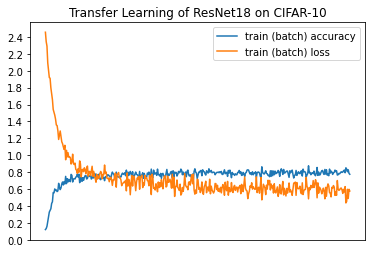

In [ ]:
# visualize the training process
plt.plot(acc_hist, label='train (batch) accuracy')
plt.plot(loss_hist, label='train (batch) loss')
plt.xticks([])
plt.yticks(torch.arange(0.0,2.5,0.2))
plt.legend()
plt.title('Transfer Learning of ResNet18 on CIFAR-10')
plt.show()

##Parts G-I: Testing the Resulting Model

In [ ]:
'''
Evaluates a given classification network of the CIFAR-10 dataset prepared above.
Input:
  > 'model' - nn.Module representing the model to test.
Output: a pair (labels, y_hat) of tensors:
  > 'labels' is a tensor list of the correct labels of the data.
  > 'y_hat' is of shape (N,c) where N is the number of test samples, and c is 
    the number of classes. Each row in this tensor is the output of the model
    on the corresponding test sample.
'''
def test_eval(model):
    with torch.no_grad():
        # initialize empty tensors for the results
        labels = torch.empty(len(test_data), device=device, dtype=torch.int64)
        y_hat = torch.empty((len(test_data), len(test_data.classes)), device=device)
        model.eval()

        # index of the next free entry in 'labels' and 'y_hat'
        nextI = 0

        # process each batch individually
        for batch_imgs, batch_labels in tqdm(test_dataloader, 'Evaluating model',
                                             position=0, leave=True):
            batch_size = len(batch_labels)
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)
            # calculate and store model output in the next entries of 'y_hat'
            y_hat[nextI : nextI+batch_size] = model(batch_imgs)
            labels[nextI : nextI+batch_size] = batch_labels
            # increase 'nextI' to reflect the stored output batch
            nextI += batch_size
        
        return labels, y_hat


In [ ]:
# get the model output on the test data
labels, y_hat = test_eval(model)

Evaluating model: 100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


In [ ]:
# calculate test loss and accuracies
loss = round(criterion(y_hat, labels).item(), 4)
predicted_labels = y_hat.argmax(dim=1)
acc = round(((predicted_labels == labels).sum()/len(labels)).item(), 4)
print(f'Test loss: {loss} | Test accuracy: {acc}')

Test loss: 0.5913 | Test accuracy: 0.8025


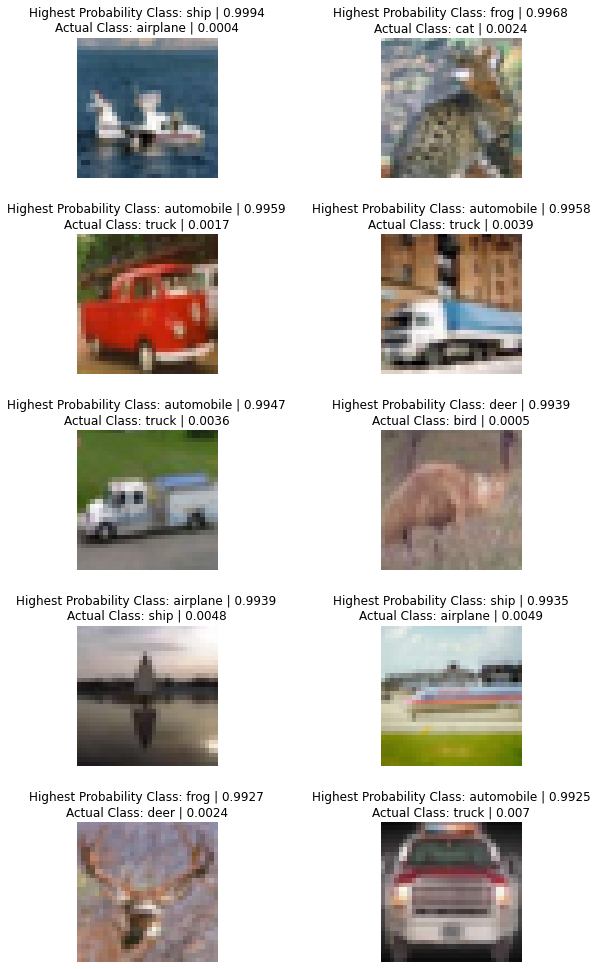

In [ ]:
''' In this cell we find and visualize the 10 worst test predictions '''

# apply softmax to the network output to obtain probabilities
softmax = nn.Softmax(dim=1)
y_probs = softmax(y_hat)

# select the probabilities of the predicted classes
predicted_probs = y_probs[torch.arange(y_probs.shape[0]),
                          predicted_labels]

# select top-10 wrong predictions
wrong_preds_probs = predicted_probs * (predicted_labels != labels)
_, top_wrong_idxs = torch.topk(wrong_preds_probs, k=10)

# visualize these samples
figure = plt.figure(figsize=(10,17))
figure.subplots_adjust(hspace=.4)
rows = 5
cols = 2

for i, n in enumerate(top_wrong_idxs):

    # get actual and predicted labels
    actual = labels[n]
    pred = predicted_labels[n]
    # get the predicted probabilities for these labels
    actual_prob = round(y_probs[n][actual].item(), 4)
    pred_prob = round(y_probs[n][pred].item(), 4)
    # get actual and predicted classes names
    actual_class = test_data.classes[actual]
    pred_class = test_data.classes[pred]

    # and visualize everything
    img = raw_test_data[n][0]
    ax = figure.add_subplot(rows, cols, i+1)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'Highest Probability Class: {pred_class} | {pred_prob}\n' +
                 f'Actual Class: {actual_class} | {actual_prob}')

plt.show()

## Part J: A Freshly New Residual Network

In [ ]:
'''
A ResNet residual block (whose main kernels are 3x3).
Credit: d2l, https://d2l.ai/chapter_convolutional-modern/resnet.html
'''
class Residual(nn.Module):
    '''
    Constructor: creates a new residual block.
    Input:
    > 'input_channels' - the number of input channels.
    > 'num_channels' - the number of output channels.
    > 'use_1x1conv' - a boolean stating whether you wish to apply a 1-by-1
      convolution for the input added directly to the output through the residual
      connection. This is necessary if the convolution is strided or the number
      of output channels is different from the number of input channels.
      Default: False.
    > 'strides' - stride for the convolutions applied on the input. Default: 1
      (no skipping).
    '''
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()

        # create main convolution layers of the block
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        
        # create 1-by-1 input convolution if necessary
        if use_1x1conv: self.conv3 = nn.Conv2d(input_channels, num_channels,
                                               kernel_size=1, stride=strides)
        else: self.conv3 = None
        
        # create batch-norm layers to apply after both main convolutions
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [ ]:
# create the required freshly-new residual network
model = nn.Sequential(
    Residual(3, 64, use_1x1conv=True, strides=2),
    Residual(64, 128, use_1x1conv=True, strides=2),
    Residual(128, 256, use_1x1conv=True, strides=2),
    nn.AdaptiveAvgPool2d((1,1)),
    nn.Flatten(),
    nn.Linear(256, len(train_data.classes))
    ).to(device)

## Part K.1: Fitting the Entire Network & Evaluating It

In [ ]:
# loss measure
criterion = nn.CrossEntropyLoss()

# an optimizer attached to all of the model's parameters
optimizer = optim.Adam(model.parameters(), lr=0.025)

# train the model
loss_hist, acc_hist = train_model(model, criterion, optimizer, epochs=5)

epoch 5 / 5: 100%|██████████| 196/196 [04:52<00:00,  1.49s/it]


Training completed in 24m 38s


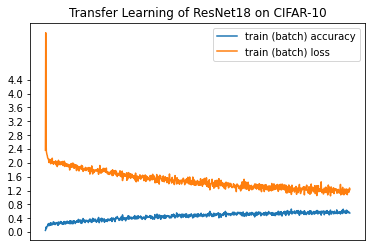

Evaluating model: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


Test loss: 1.32 | Test accuracy: 0.5347


In [ ]:
# visualize the training process
plt.plot(acc_hist, label='train (batch) accuracy')
plt.plot(loss_hist, label='train (batch) loss')
plt.xticks([])
plt.yticks(torch.arange(0.0,4.5,0.4))
plt.legend()
plt.title('Transfer Learning of ResNet18 on CIFAR-10')
plt.show()

# get the model output on the test data
labels, y_hat = test_eval(model)

# calculate test loss and accuracies
loss = round(criterion(y_hat, labels).item(), 4)
predicted_labels = y_hat.argmax(dim=1)
acc = round(((predicted_labels == labels).sum()/len(labels)).item(), 4)
print(f'\nTest loss: {loss} | Test accuracy: {acc}')

## Part K.2: Comparing the Models

Before we begin, in order to make the discussion cleaner - let us call the network produced by fitting a linear classifier on top of the pre-trained ResNet18 feature-extractor "network A", and the residual network we later trained from scratch "network B".

Now - clearly, network A was by far better than network B in terms of performance:

* Network A reached 80.25% test accuracy after 2 epochs of training, while network B reached only 53.47% test accuracy after 5 epochs of training.

* Network A reached 0.5913 test loss after 2 epochs of training, while network B reached 1.32 test loss after 5 epochs of training.

* Training network A took around 2:38 minutes per epoch (most of the time was spent on importing the images), while training network B took around 4:56 minutes per epoch - Probably due to the fact that training network B required the gradiants to flow through the entire network (while training network A required fitting the final linear-classifier only).

In general I would choose to use network A over network B, due to the following reasons:

* First, by fitting a linear classifier on top of the ResNet18 feature-extractor we managed to improve the model's performance on our toy-problem by a very large margin, and got there much quicker too. By observing these exceptional differences, I suppose that it might be a good thing to try when solving other problems as well.

* Second, fitting network A was also easier for me. I didn't have a tough time trying to choose the learning rate, and I was able to set it to a pretty small value since most of the fitting job was already done for the pre-trained ResNet18. By setting it to a small value I believe that it managed to get to a better local optimum as well. On the other hand - it took me several tries to choose a "somewhat OK" learning rate for the randomly-initialized network B, and I'm still not satisfied with the one I chose. Network B also required more training epochs (which is understandable - it is a completely-new network, so it takes more time to fit). And yet, by observing the learning curve, it is clear that the 5-epochs I gave it are not enough. In contrast, network A reached a pretty solid local optimum after only 2 epochs.

* To top all that - I generally believe that transfer-learning is a great method for solving ML problems. Think about that: ResNet18, for instance, was trained on the enormous ImageNet dataset; i.e - it was trained to classify more than a million images to a thousand different classes. All this - by using a deep feature-extractor and a simple shallow linear classifier at the top. It just makes sense that for such a general task, that feature-extractor must be a very powerfull one. Using it, or maybe even fine-tuning it for our purposes, just seems like a very efficient way to tackle a problem instead of re-training a model from scratch.

All in all, I would definetely consider using a model obtained by transfer learning - such as network A, over a freshly new model - such as network B.

GL ^_^